<a href="https://colab.research.google.com/github/NatalieGo/MFTI_hackathon_1/blob/main/dataset_analysis_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Предварительная обработка данных на основе датасета постов с Reddit (ru)

In [3]:
# знакомство с данными
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from IPython.display import display, HTML
data2 = pd.read_json('/content/drive/MyDrive/Colab/hackathon/dataset_unclean_ru.zip', compression='zip')
display(data2.head())
display(data2.info())

,0,1
0,Бывшая жена угрожает самоубийством Недавно я н...,suicide
1,"Я странный? На меня не влияют комплименты, есл...",non-suicide
2,Наконец-то 2020 год почти закончился... Так чт...,non-suicide
3,"мне нужна помощь, просто помоги мне, я так плачу",suicide
4,"Я так растеряна. Здравствуйте, меня зовут Адам...",suicide


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47997 entries, 0 to 47996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       47997 non-null  object
 1   1       47997 non-null  object
dtypes: object(2)
memory usage: 750.1+ KB


None

В данном датасете информация о постах русскоязычных пользователей, которые проходили оценку и распределялись по 2м категориям: «suicide» и «non-suicide». Датасет содержит 47997 строк, 2 столбца (с индексами «0» и «1»), оба столбца имеют тип object, нулевые значения отсутствуют.

In [4]:
# добавим название столбцов
data2.columns = ['post', 'category']
display(data2.head())

,post,category
0,Бывшая жена угрожает самоубийством Недавно я н...,suicide
1,"Я странный? На меня не влияют комплименты, есл...",non-suicide
2,Наконец-то 2020 год почти закончился... Так чт...,non-suicide
3,"мне нужна помощь, просто помоги мне, я так плачу",suicide
4,"Я так растеряна. Здравствуйте, меня зовут Адам...",suicide


In [5]:
# посмотрим статистику по столбцу category
category_counts = data2['category'].value_counts()
display(category_counts)

,count
category,
non-suicide,24081
suicide,23916


Столбец category содержит только 2 значения 'suicide', 'non-suicide'. В результате получаем количество потенциально суицидальных постов - 23916, количество нейтральных постов - 24081. Как видно из полученных цифр, значения распределяются примерно в равных долях

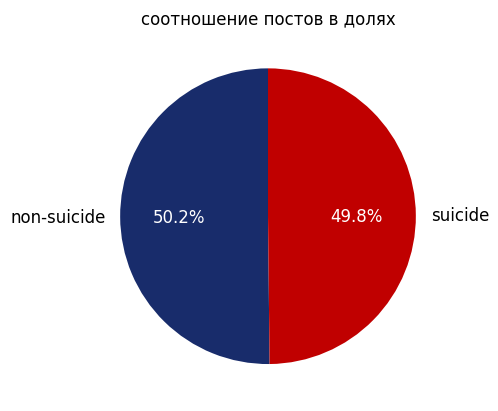

In [6]:
# построим круговую диаграмму для оценки соотношения нейтральных постов и потенциально суицидальных постов
plt.pie(category_counts, labels = ['non-suicide', 'suicide'], colors = ['#182C6B', '#C00000'], autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title('соотношение постов в долях')
for i, pct_text in enumerate(plt.gca().texts):
    if i % 2 != 0:
        pct_text.set_color('white')

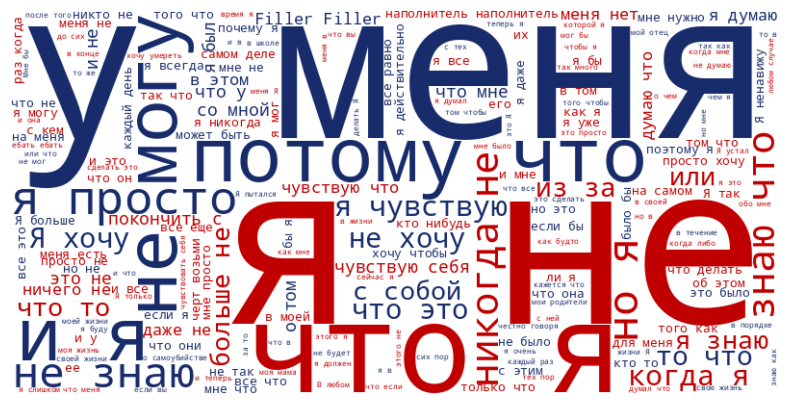

In [14]:
from wordcloud import WordCloud, STOPWORDS

text_data = ' '.join(data2['post'].astype(str))
#custom_stopwords = set(STOPWORDS)
#custom_stopwords.update(['у', 'меня', 'что'])

# Определяем кастомную цветовую функцию
def color_func(word, font_size, position, orientation, **kwargs):
    colors = ['#182C6B', '#C00000']
    return colors[np.random.randint(0, len(colors))]

# Создание облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=STOPWORDS, color_func=color_func).generate(text_data)

# Показать облако слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключить оси
plt.show()

На графике видно примерно равное соотношение постов нейтральных и суицидальных, а также долю в процентах.

In [ ]:
# посмотрим количество символов в строках с постами
data2['length'] = data2['post'].str.len()

# посмотрим статистические параметры длин постов
display(data2.groupby('category')['length'].describe())

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
non-suicide,24081.0,355.148914,790.562857,4.0,110.00,183.0,355.0,39730.0
suicide,23916.0,1112.800217,1366.363385,3.0,337.75,701.5,1372.0,36728.0


Из данного распределения видно, что посты, отмеченные как имеющие суицидальную окраску длиннее, как в среднем, так и по всем квартилям

In [ ]:
# посмотрим min (<=10) и max посты
display(data2[data2['length'] <= 10])
display(data2[data2['length'] == 39730])

,post,category,length
7342,причины,suicide,7
12625,ты :),non-suicide,5
16527,Привет:],suicide,8
19228,Привет.:),suicide,9
19372,мертвый?,suicide,8
21187,:/:/,suicide,4
23764,Тест,non-suicide,4
27196,как я ем,non-suicide,8
32415,так высоко,non-suicide,10
38133,Жизнь.....,suicide,10


,post,category,length
23629,"Roses are red, I ate a bat, According to all k...",non-suicide,39730


>часть min и max постов содержат данные, часть являются несодержательными (требуется очистка данных)
>
>посмотрим количество уникальных слов по категориям

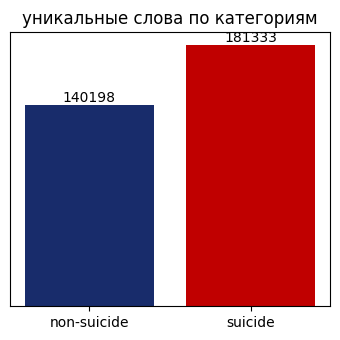

In [ ]:
# посмотрим количество уникальных слов по категориям
def unique_words_by_category(df, category_col, text_col):
  unique_words_counts = {}
  for category, group in df.groupby(category_col):
    all_posts = ' '.join(group[text_col])
    words = all_posts.lower().split()
    unique_words = set(words)
    unique_words_counts[category] = len(unique_words)
  return unique_words_counts

# посчитаем количество уникальных слов по категориям
unique_words_per_category = unique_words_by_category(data2, 'category', 'post')

# построим гистограмму
categories = list(unique_words_per_category.keys())
unique_word_counts = list(unique_words_per_category.values())

plt.figure(figsize=(3.5, 3.5))
bars = plt.bar(categories, unique_word_counts, color = ['#182C6B', '#C00000'])
plt.title('уникальные слова по категориям')
plt.grid(False)
plt.yticks([])

# добавим значения
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

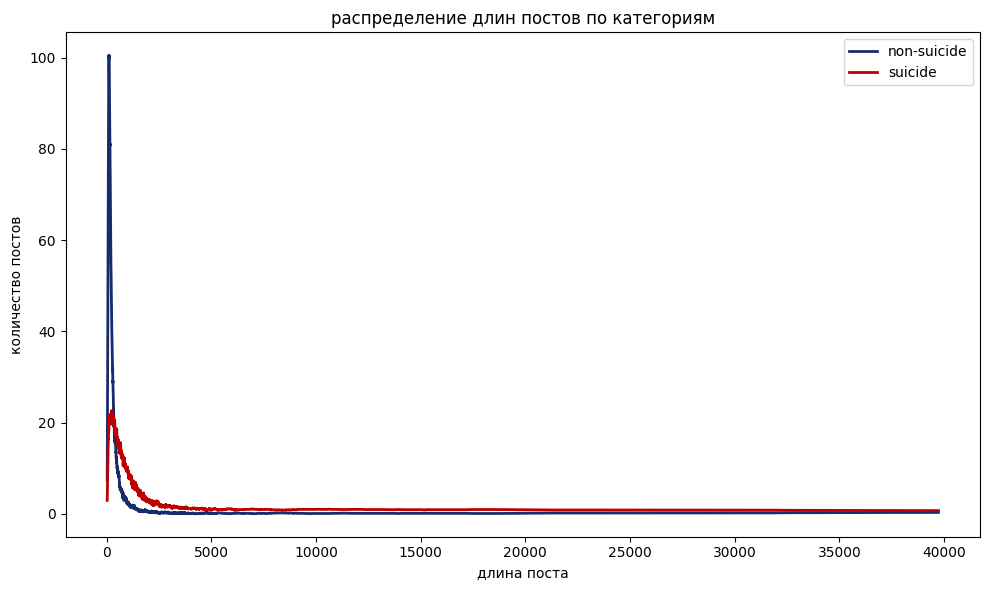

In [ ]:
# сруппируем по категориям и длине постов
length_distribution = data2.groupby('category')['length'].value_counts().unstack(fill_value=0)

# посчитаем скользящее среднее
smooth_non_suicide = length_distribution.loc['non-suicide'].rolling(window=30).mean()
smooth_suicide = length_distribution.loc['suicide'].rolling(window=30).mean()

# пострим график
plt.figure(figsize=(10, 6))

plt.plot(length_distribution.columns, smooth_non_suicide, color='#182C6B', label='non-suicide', linewidth=2)
plt.plot(length_distribution.columns, smooth_suicide, color='#C00000', label='suicide', linewidth=2)

plt.title('распределение длин постов по категориям')
plt.xlabel('длина поста')
plt.ylabel('количество постов')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()

In [ ]:
# удалим лишний столбец
data2 = data2.drop('length', axis=1)

Произведем очистку данных от лишних символов, несодержательных постов и пустых строк

In [ ]:
data2['post'] = data2['post'].str.lower()  # преобразуем строку в нижний регистр
data2['post'] = data2['post'].str.replace(r'[^\w\s]', '', regex=True)  # удаляем все символы, кроме букв, цифр и пробелов
data2['post'] = data2['post'].str.lstrip() # удаляем пробелы
data2['post'] = data2['post'].str.replace(r'\n', '', regex=True) # удаляем символы новой строки
data2['post'] = data2['post'].str.replace(r'XD', '', regex=True) # удаляем все вхождения подстроки
data2['post'] = data2['post'].str.replace(r'\s+', ' ', regex=True)  # заменяем множественные пробелы на один
data2 = data2[data2['post'].apply(lambda x: str(x).isdigit() == False)] # удаляем строки состоящие только из цифр
data2 = data2[data2['post'].str.strip() != ''] # удаляем строки с пустыми значениями
display(HTML(data2.head().to_html()))

,post,category
0,бывшая жена угрожает самоубийством недавно я навсегда ушел от жены потому что она дважды мне изменяла и так много лгала мне что я решил отказаться возвращаться к ней несколько дней назад она начала угрожать самоубийством я неустанно провел эти несколько дней отговаривая ее от этого а она продолжает колебаться потому что хочет верить что я вернусь я знаю что многие люди будут угрожать этим чтобы добиться своего но что произойдет если она действительно это сделает что мне делать и как мне пережить ее смерть на моих руках я все еще люблю свою жену но не могу смириться с тем что мне снова изменяют и постоянно чувствую себя неуверенно я волнуюсь что сегодня она может это сделать и очень надеюсь что этого не произойдет,suicide
1,я странный на меня не влияют комплименты если они исходят от когото кого я знаю но мне очень приятно когда это делают незнакомцы в интернете,non-suicide
2,наконецто 2020 год почти закончился так что я больше никогда не услышу 2020 год был плохим клянусь чертовым богом это так раздражает,non-suicide
3,мне нужна помощь просто помоги мне я так плачу,suicide
4,я так растеряна здравствуйте меня зовут адам 16 я уже много лет страдаю и боюсь за последние годы мысли о самоубийстве страхе тревоге я так близок к своему пределу я так долго молчал и боюсь рассказать семье об этих чувствах около 3 лет назад все это спровоцировало потеря тети каждый день я чувствую безнадежность потерянность вину и раскаяние по поводу нее и всего что я сделал в своей жизни но такие мысли учитывая то немногое что я испытал в жизни единственный раз когда я рассказал об этих чувствах своей семье это когда я сломался когда они увидели мои порезы наблюдение за тем как они так волнуются изза того что я описывал как обычный день заставило меня чувствовать себя совершенно ужасно позже они узнали что я пережил покушение на передозировку передозировку таблетками и попытку повешения все что произошло это потеря сознания изза таблеток и я так и не надел петлю потому что все еще очень боюсь во время первой терапии мне поставили диагноз тяжелая депрессия социальная тревожность и расстройство пищевого поведенияпозже по какойто причине меня перевели на чертову групповую терапию что заставило меня еще больше беспокоиться в конце концов перед моим последним сеансом терапии 1 на 1 она показала мне результаты ежедневной проверки моих чувств это был двухэтапный опрос для меня и моей мамыпапыприходите и узнайте что я каждый день чувствую себя ужасно и боюсьтревогу а моя мама делает все просто потрясающе и меня описывают как самого счастливого кого она когдалибо видела терапия ему помоглав конце концов мне назначили серталин антитревожный или антидепрессивный препарат извините я забыл но я так и не закончил свой первый рецепт и не нашел подходящего типа антидепрессанта потому что моя мама думала что мне нужны только лекарства поэтому она сняла меня с курса рекомендовал график приема таблеток примерно через 3 недели и остановил меня от их приема все это время я чувствовал себя еще хуже опасаясь причиненного им ущербабеспокойстватеперь когда все происходит я напуган так же как никогда у меня случился рецидив после резки и у меня развилась тяжелая бессонница день за днем я чувствую себя все более безнадежным никчемным и задаюсь вопросом почему я все еще здесь какова моя мотивация встать с постели и продолжать идти я задаю это себе почти каждую ночь почти каждый раз срываясьпожалуйста пожалуйста пожалуйста ктонибудь ктонибудь помогите мнея так боюсь что могу сделать чтото радикальное меня сформировали страх и тревога я не знаю что делать дальше,suicide


Заменим значения в столбце category на числовые для более простой обработки

In [ ]:
data2['category'] = data2['category'].astype('category').cat.codes

In [ ]:
#снова посчитаем данные о количестве постов
display(data2.info())
display(data2['category'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 47991 entries, 0 to 47996
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   post      47991 non-null  object
 1   category  47991 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 796.7+ KB


None

,count
category,
0,24077
1,23914


Теперь датасет очищен от лишних символов, и содержит прверенные данные.

In [ ]:
# сохраним датасет в csv файл
data2.to_csv('/content/dataset_clean_ru.csv', index=False, sep=';')